# Stochastic Gradient Hamiltonian Monte Carlo

#### Kezi Cheng, Michael Lee, Daniel Olal, Victor Sheng
#### Harvard University, 29 Oxford Street, Cambridge MA 02138

In [491]:
from autograd import numpy as np
from autograd import grad
from autograd import scipy as sp

from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import scipy
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

#### Bimodal distribution used for unit testing purposes (making sure samplers work)

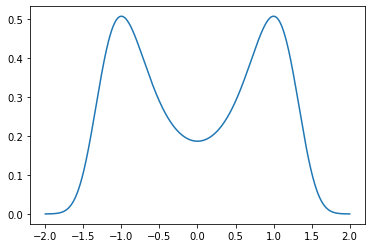

In [98]:
# Bimodal PDF for testing

# %% set up functions 
U = lambda x: (-2.* x**2 + x**4)

gradU = lambda x: ( -4.* x +  4.*x**3) +  np.random.randn(1) * 2.
gradUPerfect =  lambda x: ( -4.* x +  4.*x**3) 
PDF = lambda x: np.exp(-U(x))

xStep = 0.001;
interval = (2 - (-2)) / xStep
x_range = np.linspace(-2, 2, interval)
y_range = PDF(x_range)
y_range = y_range / sum(y_range) / xStep

plt.plot(x_range, y_range)
plt.show()

#### Generate a dataset for simple bivariate linear regression (regress Y on X)

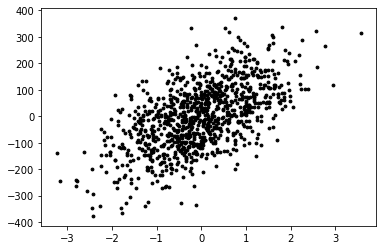

In [99]:
# generate regression dataset
X, y = make_regression(n_samples=1000, bias = 0, n_features=1, noise=100, random_state=123)
# plot regression dataset
plt.scatter(X, y, color = 'black', s = 8)
plt.show()

#### Fit regression line to the data

Coefficients: 2.6958526425591325 [72.52487439]
MSE: 9882.09
R^2: 0.35


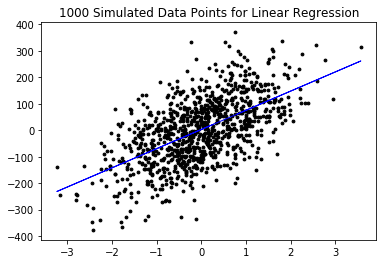

In [470]:
regr = LinearRegression()
regr.fit(X, y)
y_pred = regr.predict(X)

print('Coefficients:', regr.intercept_, regr.coef_)
print('MSE: %.2f' % mean_squared_error(y, y_pred))
print('R^2: %.2f' % r2_score(y, y_pred))

plt.scatter(X, y,  color='black', s=8)
plt.plot(X, y_pred, color='blue', linewidth=1)
plt.title("1000 Simulated Data Points for Linear Regression")
plt.savefig('data/regression_data.png', bbox_inches="tight")
plt.show()

#### Collection of vanilla HMC samplers for comparison

In [101]:
#### this is the author's implementation of HMC, may need to be refined to work in multi-dimensional case

#%% HMC using gradU, for nstep, starting at position x

def hmc_auth(U, gradU, m, dt, nstep, x, mhtest):
    
    # U: potential energy function
    # gradU: dU/dx
    # m: variance of the Gibbs distribution for kinetic energy
    # dt: time interval epsilon
    # nstep: number of leapfrog steps
    # x: position
    # mhtest: binary flag to turn on MH correction step
  
    #p = np.random.randn(len(x)) * np.sqrt(m) 
    
    # sample random momentum
    p = np.random.randn(1) * np.sqrt(m)
    #p = p.reshape(-1,1)
    p_prime = p.T
    oldX = x
    
    # hamiltonian function (total energy)
    oldEnergy = np.dot(p_prime, m * p) / 2 + U(x)

    # do leapfrog
    for i in range (1, nstep + 1):
        p = p - gradU( x ) * dt / 2
        x = x + p / m * dt
        p = p - gradU( x ) * dt / 2
        #end
    
    p = -p # flip sign

    # M-H test
    if mhtest != 0:
        #p = p.reshape(-1,1)
        #p_prime = p.reshape(1,-1)
        p_prime = p.T
        newEnergy  = np.dot(p_prime, m * p) / 2  + U(x)

        if np.exp(oldEnergy- newEnergy) < np.random.rand(1):
            x = oldX # reject and stick with old position
    
    return x

In [102]:
## Note: this implementation is heavily inspired by this library:
## https://github.com/ColCarroll/minimc

def hmc_cc(n_samples, negative_log_prob, initial_position, burn_in=500, path_len=1, step_size=0.1):

    initial_position = np.array(initial_position)

    # compute gradient
    dUdq = grad(negative_log_prob)

    # list to store samples
    samples = [initial_position]

    # Euclidean-Gaussan Kinetic Energy, with mass m = 1
    momentum = scipy.stats.norm(0, 1)

    size = (n_samples + burn_in,) + initial_position.shape[:1]

    for p0 in momentum.rvs(size=size):

        # simulate movement using Leapfrog Integrator
        q, p = np.copy(samples[-1]), np.copy(p0)

        p -= step_size * dUdq(q) / 2
        
        for _ in np.arange(np.round(path_len / step_size) - 1):
            #print(q, q.shape, p, p.shape)
            q += step_size * p  
            p -= step_size * dUdq(q)
            
        q += step_size * p  
        p -= step_size * dUdq(q) / 2  

        # flip momentum
        q_new = q
        p_new = -p

        #  Metropolis-Hastings step
        start_log_p = np.sum(momentum.logpdf(p0)) - negative_log_prob(samples[-1])
        new_log_p = np.sum(momentum.logpdf(p_new)) - negative_log_prob(q_new)

        p_accept = min(1, np.exp(new_log_p - start_log_p))

        if np.random.rand() < p_accept:
            samples.append(q_new)
        else:
            samples.append(np.copy(samples[-1]))

    # return samples, omitting burn-in section
    return np.array(samples[1 + burn_in :])


In [9]:
#### this is the HMC implementation from the original HMC paper (Radford Neal, 2012)
## https://arxiv.org/pdf/1206.1901.pdf (page 14)

# potential energy U determined by position
# kinetic energy K determined by momentum

# change in position q for each time step: dq/dt = p
# change in momentum p for each time step: -dU/dq (aka -grad_U(q))

def hmc_neal(U, grad_U, epsilon, L, current_q):
    
    q = current_q

    p = np.random.standard_normal(1).item(0) # independent standard normal variates
    current_p = p
    
    # Make a half step for momentum at the beginning
    p = p - epsilon * grad_U(q) / 2
    
    # Alternate full steps for position and momentum
    for i in range(L):
        
        # Make a full step for the position
        q = q + epsilon * p
        
        # Make a full step for the momentum, except at end of trajectory
        if i != L-1:
            p = p - epsilon * grad_U(q)
    
    # Make a half step for momentum at the end.
    p = p - epsilon * grad_U(q) / 2
    
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q)
    current_K = np.sum(current_p**2) / 2
    proposed_U = U(q)
    proposed_K = np.sum(p**2) / 2
    
    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    if np.random.uniform(0, 1, size = 1) < np.exp(current_U - proposed_U + current_K - proposed_K):
        return q # accept
    else:
        return current_q # reject


#### Perform unit tests on HMC implementations

In [20]:
samples_hmc_neal = []
x = 0.
for i in range(80000):
    x = hmc_neal(U, gradUPerfect, 0.1, 5, x)
    samples_hmc_neal.append(x)

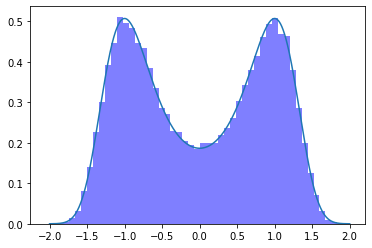

In [21]:
plt.plot(x_range, y_range)
plt.hist(samples_hmc_neal, density = True, bins = 50, color = 'blue', alpha = 0.5)
plt.show()

In [16]:
%time samples_hmc_cc = hmc_cc(n_samples = 10000, negative_log_prob = U, initial_position = np.array([0.]), burn_in=1000, path_len=5, step_size=0.1)

Wall time: 2min 20s


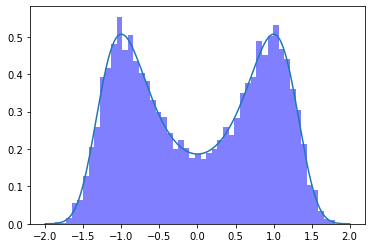

In [17]:
plt.plot(x_range, y_range)
plt.hist(samples_hmc_cc, density = True, bins = 50, color = 'blue', alpha = 0.5)
plt.show()

#### SGHMC Implementations

In [50]:
# Author's SGHMC implementation (may only work for 1 dimensional case)

# SGHMC using gradU, for nstep, starting at position x

# U - potential energy function (negative log pdf)
# gradU - gradient of potential energy function
# m - mass 
# dt - step size
# nstep - number of leapfrog steps
# x - position
# C - user specified friction term
# V - covariance of stochastic gradient noise


def sghmc_auth(U, gradU, m, dt, nstep, x, C, V):
    
    p = np.random.randn(1) * np.sqrt(m) # sampling momentum
    B = 0.5 * V * dt # noise model estimate
    D = np.sqrt( 2 * (C - B) * dt ) # covariance of the noise model

    for i in range(1, nstep + 1):
        p = p - gradU( x ) * dt  - p * C * dt  + np.random.randn(1) * D # momentum update
        x = x + p/m * dt # position update

    return x # return position

In [358]:
# multivariate implementation of SGHMC
# insipired by: https://github.com/gldmt-duke/CokerAmitaiSGHMC/blob/master/sghmc/sghmc.py

def sghmc_adv(U, gradU, M, dt, nstep, theta, C, V, num_samples, MH = False):
    
    # theta: 1xk VECTOR
    # M: kxk MATRIX
    # C: kxk MATRIX
    # V: kxk MATRIX
    
    # if given scalars, covert everything to 1x1 matrices
    if np.isscalar(theta):
        k = 1
        theta = np.array([[theta]])
        M = np.array([[M]])
        C = np.array([[C]])
        V = np.array([[V]])
        
    else: # if multidimensional
        k = theta.size
        M = np.diag(M)
        C = np.diag(C)
        #V = np.diag(V)
    
    M_inv = np.linalg.inv(M) # typically, M is chosen to be the identity matrix
    B_hat = 0.5 * V * dt
    D = 2 * (C - B_hat) * dt
    
    # mini-batch estimate of gradient
    noisy_gradU = gradU
    
    # handle case when len_theta = 1
    if k > 1:
        generated_samples = np.zeros((num_samples, k))
    else:
        generated_samples = np.zeros(num_samples)
        
    num_accepted = num_samples
    
    for i in range(num_samples):

        # TO DO: to speed up, drawn all MVN samples in a single call, then iterate through rows
        momentum = np.random.multivariate_normal(np.zeros(k), M) # sample momentum from MVN(0, M)
        
        momentum_prev = np.copy(momentum)

        for _ in range(nstep):
            theta = theta + dt * M_inv @ momentum
            momentum = momentum - dt * noisy_gradU(theta) - dt * C @ M_inv @ momentum + np.random.multivariate_normal(np.zeros(k), D)
            
        # optional MH step (taken from hmc_cc function but not extensively tested)
        if MH is True:
            
            theta_new = theta
            momentum_new = momentum

            start_log_p = np.sum(scipy.stats.norm(0, 1).logpdf(momentum_prev)) - U(generated_samples[-1])
            new_log_p = np.sum(scipy.stats.norm(0, 1).logpdf(momentum_new)) - U(theta_new)

            p_accept = min(1, np.exp(new_log_p - start_log_p))

            if np.random.rand() < p_accept:
                generated_samples[i] = theta_new
            else:
                generated_samples[i] = np.copy(generated_samples[-1])
                num_accepted -= 1
        else:
            # record generated sample
            generated_samples[i] = theta
    
    #print(num_accepted/num_samples)
    return generated_samples

In [359]:
scipy.stats.norm(0, 1).logpdf(np.array([9, 3]))

array([-41.41893853,  -5.41893853])

#### SGHMC Unit Tests

In [167]:
%%time

m = 1;
C = 3;
dt = 0.1;
nstep = 50;
V = 4;

samples_sghmc = []
x = np.array([0])

for i in range(80000):
    x = sghmc_auth(U, gradU, m, dt, nstep, x, C, V);
    samples_sghmc.append(x.item(0))

Wall time: 1min 16s


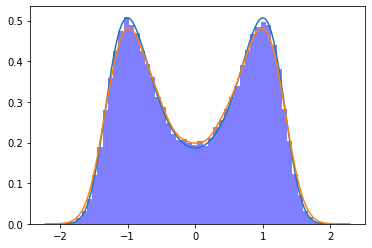

In [168]:
plt.plot(x_range, y_range)
plt.hist(samples_sghmc, density = True, bins = 50, color = 'blue', alpha = 0.5)
seaborn.kdeplot(samples_sghmc)
plt.show()

In [31]:
%time sghmc_bimodal_samples = sghmc_adv(U, gradU, M = 1, dt = 0.1, nstep = 50, theta = 0, C=3, V=4, num_samples = 80000, MH = False)

1.0
Wall time: 11min 5s


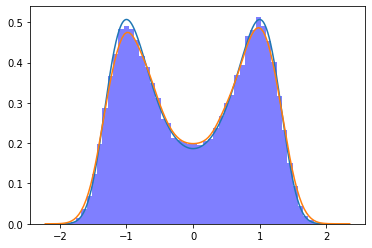

In [32]:
plt.plot(x_range, y_range)
plt.hist(sghmc_bimodal_samples, density = True, bins = 50, color = 'blue', alpha = 0.5)
seaborn.kdeplot(sghmc_bimodal_samples)
plt.show()

### Sampling from Bivariate Normal Distribution

In [292]:
# potential energy U for MVN distribution (negative log pdf)
# inspired by helper functions from this library: https://github.com/ColCarroll/minimc
def neg_log_mvnormal(mu, sigma):
    
    def logp(x):
        k = mu.shape[0]
        return 0.5 * (k * np.log(2 * np.pi) 
                      + np.log(np.linalg.det(sigma)) 
                      + np.dot(np.dot((x - mu).T, np.linalg.inv(sigma)), x - mu))

    return logp

To test our sampler in the multivariate case, try sampling from $\mathcal{N}\left([120, 4], \left[\begin{array}{cc} 1.5 & 1\\ 1 & 1.5 \end{array} \right] \right)$

In [293]:
# get the negative log pdf and its gradient for the multivariate normal distribution we're sampling from
neg_log_mvn_pdf = neg_log_mvnormal(mu = np.array([120, 4]), sigma = np.array([[1.5, 1], [1, 1.5]]))
neg_log_mvn_pdf_grad = grad(neg_log_mvn_pdf)

# evaluating the negative log pdf and its gradient at different points to test what the output looks like
neg_log_mvn_pdf((np.array([3, 4]))), neg_log_mvn_pdf_grad((np.array([5, 1])))

(8215.349448842066, array([-134,   88]))

In [294]:
mvn_sghmc_samples = sghmc_adv(neg_log_mvn_pdf , neg_log_mvn_pdf_grad, M = np.array([1, 1]), dt = 0.1, nstep = 50, theta = np.array([120., 4.]), 
                                    C=np.array([1, 1]), V=np.array([0, 0]), num_samples = 1000)

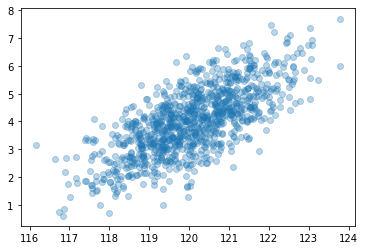

In [295]:
plt.scatter(mvn_sghmc_samples[:,0], mvn_sghmc_samples[:,1], alpha = 0.3)


In [296]:
%time true_mvn_samples = np.random.multivariate_normal(np.array([120, 4]), np.array([[1.5, 1], [1, 1.5]]), 1000)
#true_samples

Wall time: 985 µs


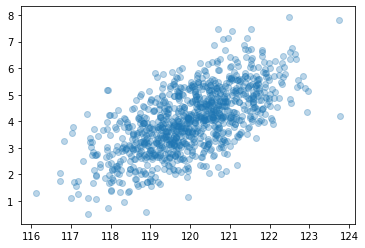

In [297]:
plt.scatter(true_mvn_samples[:,0], true_mvn_samples[:,1], alpha = 0.3)
plt.show()

In [298]:
np.cov(true_mvn_samples, rowvar=False)

array([[1.42807444, 0.92996368],
       [0.92996368, 1.4648376 ]])

In [299]:
%time mvn_hmc_samples = hmc_cc(n_samples = 1500, negative_log_prob = neg_log_mvn_pdf, initial_position = [120., 4.], burn_in=500, path_len=3, step_size=0.1)

Wall time: 27.3 s


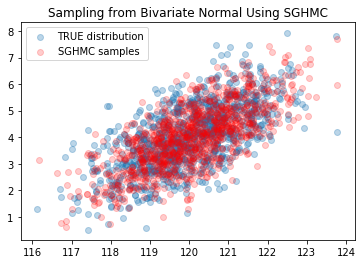

In [454]:
plt.scatter(true_mvn_samples[:,0], true_mvn_samples[:,1], alpha = 0.3, label = "TRUE distribution")
#plt.scatter(mvn_hmc_samples[:,0], mvn_hmc_samples[:,1], alpha = 0.3, color = 'orange', label = "HMC samples")
plt.scatter(mvn_sghmc_samples[:,0], mvn_sghmc_samples[:,1], alpha = 0.2, color = 'red', label = "SGHMC samples")
plt.title("Sampling from Bivariate Normal Using SGHMC")
plt.savefig('data/mvn_unit_test.png', bbox_inches="tight")
plt.legend()
plt.show()

### Bayesian Linear Regression (Bivariate Normal Posterior)

We model the outcome $y$ as follows:
\begin{aligned}
y &= f(x) + \epsilon = w_1x + w_0 + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2), \; \sigma^2 = 10 \\
w_0 &\sim \mathcal{N}(0, 1)\\
w_1 &\sim \mathcal{N}(0, 0.5)
\end{aligned}

We can write $y$ as multivariate normal: $y \sim \mathcal{N}(Xw, \Sigma)$ where $\Sigma = \sigma^2I_{n\times n}$, where $n$ is the number of data points.

Since the likelihood is normal, we also choose conjugate normal priors for $w_0$ and $w_1$: $p(w_0) = \mathcal{N}(0, 1)$, $p(w_1) = \mathcal{N}(0, 0.5)$

The priors can also be expressed as a multivariate Gaussian. Since the $p(w_0)$, $p(w_1)$ are both univariate Gaussians and we've assumed in our prior that they are independent, the joint distribution over $w_0$ and $w_1$ is a bivariate Gaussian with mean $m = [0\;\; 0]$ and covariance matrix $S = \left[\begin{array}{cc} 0.5 & 0\\ 0 & 1 \end{array} \right]$:
$$
w\sim \mathcal{N}\left([0\;\; 0], \left[\begin{array}{cc} 0.5 & 0\\ 0 & 1 \end{array} \right] \right).
$$

Bayesian linear regression has a closed form solution. The posterior $p(w | \mathbf{y}, \mathbf{X})$ has the form of a multivariate Gaussian:
$$
p(w | \mathbf{y}, \mathbf{X}) = \mathcal{N}\left(\left(S^{-1} + \mathbf{X}^\top\Sigma^{-1}\mathbf{X}\right)^{-1} \left(\mathbf{y}^\top \Sigma^{-1}\mathbf{X} + m^\top S^{-1} \right)^\top, \left(S^{-1} + \mathbf{X}^\top\Sigma^{-1}\mathbf{X}\right)^{-1}\right).
$$

In [255]:
# following example from AM207 HW0

# reshape our data X, y so that we can perform the necessary matrix multiplication
x_matrix = np.hstack((X.reshape((-1, 1)), np.ones(X.shape)))
y_matrix = y.reshape((-1, 1))

# prior means for (beta_1, beta_0) aka (slope, intercept)
m = np.array([0, 0])

# prior covariance matrix
S = np.diag((0.5, 1))
S_inv = np.linalg.inv(S)

# covariance matrix of epsilon noise
sigma = 10 * np.eye(x_matrix.shape[0])
sigma_inv = np.linalg.inv(sigma)

# Bayesian linear regression has a closed form solution! The posterior is multivariate normal
# We directly solve for the mean and variance of this multivariate normal distribution

#defining the posterior variance
posterior_cov = np.linalg.inv(S_inv + x_matrix.T @ sigma_inv @ x_matrix)

#defining the posterior mean
posterior_mean = posterior_cov @ (y_matrix.T @ sigma_inv @ x_matrix + m.T @ S_inv).T

In [45]:
print("Posterior Mean: ", posterior_mean.flatten(), "\n")
print("Posterior Covariance: \n\n", posterior_cov)

Posterior Mean:  [71.10399927  2.61350193] 

Posterior Covariance: 

 [[0.00978865 0.00038345]
 [0.00038345 0.00991601]]


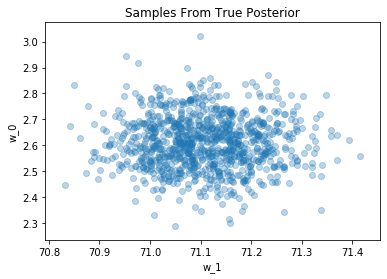

In [258]:
# sampling from the true posterior using Numpy
posterior_samples = np.random.multivariate_normal(posterior_mean.flatten(), posterior_cov, size=1000)

# visualize the true posterior (multivariate normal)
fig, ax = plt.subplots(1, 1)
ax.scatter(posterior_samples[:, 0], posterior_samples[:, 1], alpha=0.3)
ax.set_xlabel('w_1')
ax.set_ylabel('w_0')
ax.set_title('Samples From True Posterior')
plt.show()

In [52]:
# try defining potential energy U and gradU, evaluate them at a point to test their output
neg_logp = neg_log_mvnormal(mu = posterior_mean.flatten(), sigma = posterior_cov)
neg_logp_grad = grad(neg_logp)

neg_logp((np.array([20.3, -1.8]))), neg_logp_grad((np.array([20.3, -1.8])))

(0.7230345543424477, array([-7.18364023, -9.74624714]))

In [53]:
# function that allows us to compute a perfect gradient or noisy gradient of potential energy function U
# noisy gradient is computed using a subsample (mini-batch) of the full data

def ols_gradient(noisy = False, batch_size = 50):
    
    x_matrix = np.hstack((X.reshape((-1, 1)), np.ones(X.shape)))
    y_matrix = y.reshape((-1, 1))

    # prior means
    m = np.array([0, 0])
    
    # prior covariance matrix
    S = np.diag((0.5, 1))
    S_inv = np.linalg.inv(S)
    
    if noisy:
        sigma = 10 * np.eye(batch_size)
    else:
        sigma = 10 * np.eye(x_matrix.shape[0])
            
    sigma_inv = np.linalg.inv(sigma)
    
    def gradient_func(w):
        
        # if noisy, select a random minibatch of the data
        if noisy:
            idx = np.random.choice(x_matrix.shape[0], batch_size, replace=False)
            scaling_factor = x_matrix.shape[0] / batch_size
        else:
            idx = np.arange(x_matrix.shape[0])
            scaling_factor = 1
        
        #print(noisy, batch_size, idx)

        #defining the posterior variance
        posterior_cov = np.linalg.inv(S_inv + x_matrix[idx].T @ sigma_inv @ x_matrix[idx])

        #defining the posterior mean
        posterior_mean = posterior_cov @ (y_matrix[idx].T @ sigma_inv @ x_matrix[idx] + m.T @ S_inv).T

        neg_logp = neg_log_mvnormal(mu = posterior_mean.flatten(), sigma = posterior_cov)
        neg_logp_grad = grad(neg_logp)
        
        return neg_logp_grad(w) * scaling_factor
    
    return gradient_func
    

#### Estimate gradient noise for fixed batch size and theta values

In [82]:
# [beta_1, beta_0]
test_point = np.array([20.3, -1.8])
test_point = np.array([20.8, -1.5])

In [83]:
# exact gradient at test point
ols_gradient(noisy = False, batch_size = 150)(test_point)

array([-5130.53377737,  -216.44026732])

In [84]:
# noisy gradient at test point
ols_gradient(noisy = True, batch_size = 150)(test_point)

array([-5682.64405358,   142.90793865])

In [85]:
noisy_gradients_list = []

for i in range(5000):
    noisy_gradients_list.append(ols_gradient(noisy = True, batch_size = 150)(test_point))
    
noisy_gradients = np.array(noisy_gradients_list)
noisy_gradients

array([[-4075.40136593,  -820.66036969],
       [-4657.69713005, -1892.1237667 ],
       [-4099.57274103,   390.70910492],
       ...,
       [-4195.76931996,  -682.07646721],
       [-4846.12339062,  -235.75089861],
       [-7496.40270842, -1334.64825644]])

In [86]:
# to isolate the noise, we subtract the true gradient from each of the noisy gradient estimates
gradient_noise = noisy_gradients - ols_gradient(noisy = False, batch_size = 150)(test_point)
gradient_noise

array([[ 1055.13241144,  -604.22010237],
       [  472.83664733, -1675.68349938],
       [ 1030.96103634,   607.14937224],
       ...,
       [  934.76445741,  -465.63619989],
       [  284.41038675,   -19.31063129],
       [-2365.86893105, -1118.20798912]])

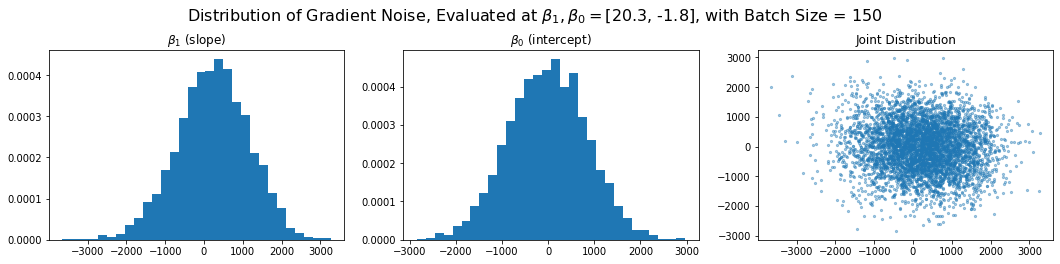

In [487]:
fig, ax = plt.subplots(1, 3, figsize = (18, 3.5))

ax[0].hist(gradient_noise[:,0], bins  = 30, density = True)
ax[0].set_title("$\\beta_1$ (slope)")
ax[1].hist(gradient_noise[:,1], bins  = 30, density = True)
ax[1].set_title('$\\beta_0$ (intercept)')
ax[2].scatter(gradient_noise[:,0], gradient_noise[:, 1], s=5,alpha=0.4)
ax[2].set_title("Joint Distribution")


fig.suptitle("Distribution of Gradient Noise, Evaluated at $\\beta_1, \\beta_0 = $[20.3, -1.8], with Batch Size = 150", va = 'top', size = 16, y=1.05)
plt.savefig('data/gradient_noise.png', bbox_inches="tight")
plt.show()

In [89]:
# estimate the mean and covariance of the gradient noise
noise_mean = np.mean(gradient_noise, axis=0)
noise_cov = np.cov(gradient_noise, rowvar=False)

print("Gradient Noise Mean: ", noise_mean, "\n")
print("Gradient Noise Covariance: \n\n", noise_cov)

Gradient Noise Mean:  [230.05150871 -12.34229605] 

Gradient Noise Covariance: 

 [[859191.9818051  -60895.45186205]
 [-60895.45186205 704638.37734254]]


In [90]:
np.var(gradient_noise[:,0]), np.var(gradient_noise[:,1])

(859020.1434087362, 704497.4496670701)

In [205]:
%%time

# vanilla HMC samples for comparison
hmc_ols_samples = hmc_cc(n_samples = 1500, negative_log_prob = neg_log_mvnormal(mu = posterior_mean.flatten(), sigma = posterior_cov), 
                         initial_position = [20., -1.], burn_in=500, path_len=3, step_size=0.1)

Wall time: 29.7 s


#### Generate posterior samples using SGHMC, trying different hyperparameters

In [437]:
%%time

C = np.array([[50, 0], [0, 50]])
noise_matrix = np.diag([10000, 10000])

sghmc_ols_samples = sghmc_adv(neg_log_mvnormal(mu = posterior_mean.flatten(), sigma = posterior_cov),
                              ols_gradient(noisy = True, batch_size = 500), M = np.array([1, 1]), 
                              dt = 0.001, nstep = 50, theta = np.array([71., 2.5]), 
                              C=np.array([10, 10]), V=noise_matrix,
                              num_samples = 500, MH = False)

Wall time: 43.3 s


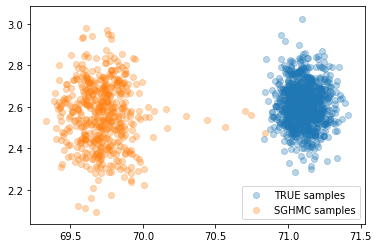

In [438]:
plt.scatter(posterior_samples[:, 0], posterior_samples[:,1], alpha=0.3, label='TRUE samples')
plt.scatter(sghmc_ols_samples[:,0], sghmc_ols_samples[:,1], alpha =0.3, label='SGHMC samples')
#plt.scatter(hmc_ols_samples[:,0], hmc_ols_samples[:,1], alpha = 0.15, label='HMC samples')
plt.legend()
plt.savefig('data/trial_error.png', bbox_inches="tight")
plt.show()

### Trying Different Batch Sizes

In [411]:
batch_sizes = [250, 500, 750, 1000]
minib_samples = []

for minib_size in batch_sizes:
    samples = sghmc_adv(neg_log_mvnormal(mu = posterior_mean.flatten(), sigma = posterior_cov),
                              ols_gradient(noisy = True, batch_size = minib_size), M = np.array([1, 1]), 
                              dt = 0.001, nstep = 50, theta = np.array([71., 2.5]), 
                              C=np.array([10, 10]), V=np.zeros((2,2)),
                              num_samples = 500, MH = False)
    
    minib_samples.append(samples)
    

In [416]:
def plot_figures(samples_list, param_list, param_name, title, img_name):

    fig, ax = plt.subplots(1, 4, figsize=(18, 3.75), sharex = True, sharey = True)

    ax[0].scatter(posterior_samples[:, 0], posterior_samples[:,1], alpha=0.3, label='TRUE samples')
    ax[0].scatter(samples_list[0][:,0], samples_list[0][:,1], alpha =0.3, label='SGHMC samples')
    ax[0].set_title(param_name + f" = {param_list[0]}")
    ax[0].legend(loc='lower right')
    ax[1].scatter(posterior_samples[:, 0], posterior_samples[:,1], alpha=0.3, label='TRUE samples')
    ax[1].scatter(samples_list[1][:,0], samples_list[1][:,1], alpha =0.3, label='SGHMC samples')
    ax[1].set_title(param_name + f" = {param_list[1]}")
    ax[1].legend(loc='lower right')
    ax[2].scatter(posterior_samples[:, 0], posterior_samples[:,1], alpha=0.3, label='TRUE samples')
    ax[2].scatter(samples_list[2][:,0], samples_list[2][:,1], alpha =0.3, label='SGHMC samples')
    ax[2].set_title(param_name + f" = {param_list[2]}")
    ax[2].legend(loc='lower right')
    ax[3].scatter(posterior_samples[:, 0], posterior_samples[:,1], alpha=0.3, label='TRUE samples')
    ax[3].scatter(samples_list[3][:,0], samples_list[3][:,1], alpha =0.3, label='SGHMC samples')
    ax[3].set_title(param_name + f" = {param_list[3]}")
    ax[3].legend(loc='lower right')

    fig.text(0.5, -0.05, '$\\beta_1$ (slope)', ha='center', size = 12)
    fig.text(-0.01, 0.5, '$\\beta_0$ (intercept)', va='center', rotation='vertical', size = 12)
    fig.suptitle(title, va = 'top', size = 16, y=1.1)

    plt.tight_layout()
    plt.savefig('data/' + img_name, bbox_inches="tight")
    plt.show()

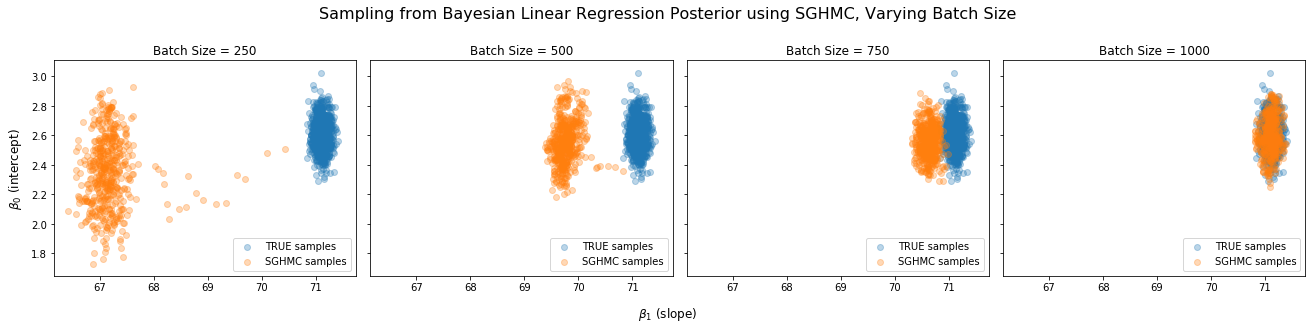

In [417]:
plot_figures(samples_list = minib_samples, param_list = batch_sizes, param_name = "Batch Size", title = "Sampling from Bayesian Linear Regression Posterior using SGHMC, Varying Batch Size", img_name = "vary_batch_sizes.png")

#### Trying Different Friction Settings

In [455]:
friction_options = [np.array([0,0]), np.array([10,10]), np.array([50,50]), np.array([100,100])]
friction_samples = []

for friction_matrix in friction_options:
    samples = sghmc_adv(neg_log_mvnormal(mu = posterior_mean.flatten(), sigma = posterior_cov),
                              ols_gradient(noisy = True, batch_size = 500), M = np.array([1, 1]), 
                              dt = 0.001, nstep = 50, theta = np.array([71., 2.5]), 
                              C=friction_matrix, V=np.zeros((2,2)),
                              num_samples = 500, MH = False)
    
    friction_samples.append(samples)
    

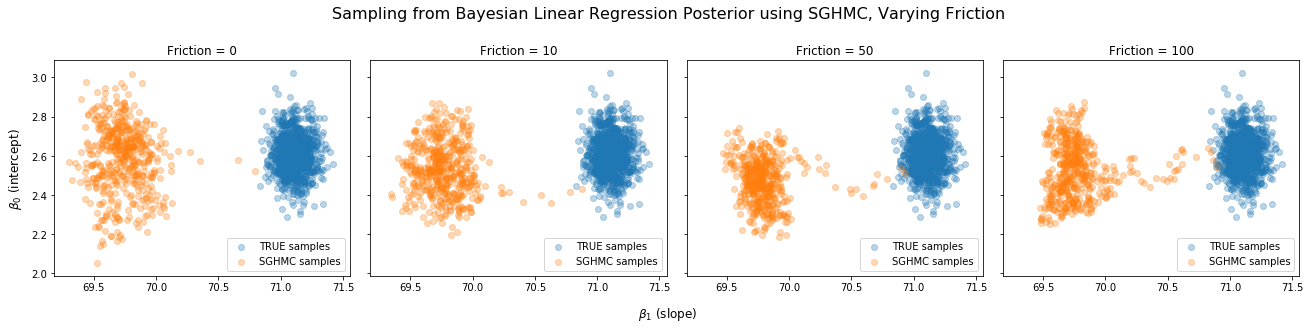

In [456]:
friction_option_labels = [0, 10, 50, 100]
plot_figures(samples_list = friction_samples, param_list = friction_option_labels, param_name = "Friction", title = "Sampling from Bayesian Linear Regression Posterior using SGHMC, Varying Friction", img_name = "vary_friction.png")

#### Trying Different Noise Estimates

In [467]:
noise_options = [np.diag([0,0]), np.diag([10,10]), np.diag([500,500]), np.diag([1000,1000])]
noise_samples = []

for noise_matrix in noise_options:
    samples = sghmc_adv(neg_log_mvnormal(mu = posterior_mean.flatten(), sigma = posterior_cov),
                              ols_gradient(noisy = True, batch_size = 500), M = np.array([1, 1]), 
                              dt = 0.001, nstep = 50, theta = np.array([71., 2.5]), 
                              C=np.array([10, 10]), V=noise_matrix,
                              num_samples = 500, MH = False)
    
    noise_samples.append(samples)
    

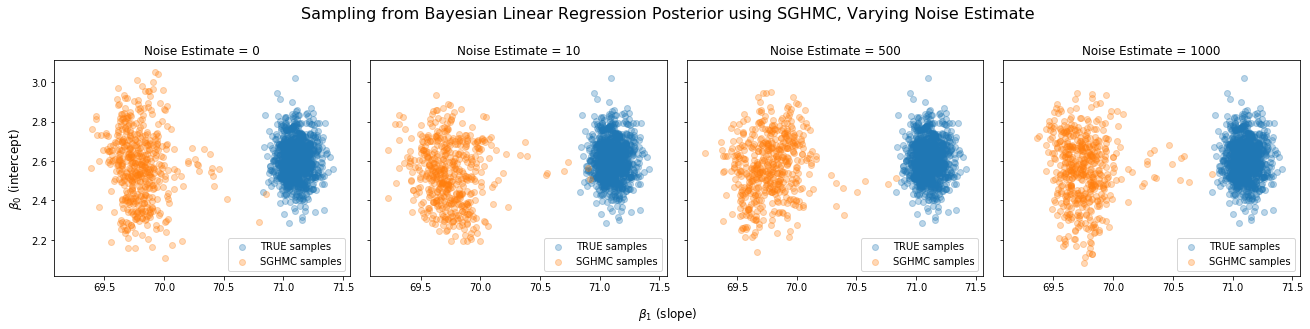

In [468]:
noise_option_labels = [0, 10, 500, 1000]
plot_figures(samples_list = noise_samples, param_list = noise_option_labels, param_name = "Noise Estimate", title = "Sampling from Bayesian Linear Regression Posterior using SGHMC, Varying Noise Estimate", img_name = "vary_noise.png")

### Trying Different Step Sizes

In [465]:
step_options = [0.0001, 0.0005, 0.001, 0.005]
step_samples = []

for step_size in step_options:
    samples = sghmc_adv(neg_log_mvnormal(mu = posterior_mean.flatten(), sigma = posterior_cov),
                              ols_gradient(noisy = True, batch_size = 500), M = np.array([1, 1]), 
                              dt = step_size, nstep = 50, theta = np.array([71., 2.5]), 
                              C=np.array([10, 10]), V=np.zeros((2,2)),
                              num_samples = 500, MH = False)
    
    step_samples.append(samples)
    

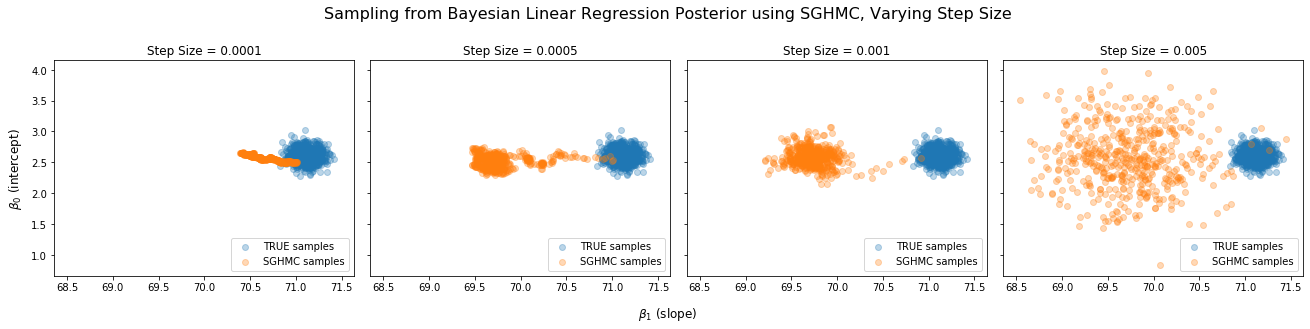

In [466]:
plot_figures(samples_list = step_samples, param_list = step_options, param_name = "Step Size", title = "Sampling from Bayesian Linear Regression Posterior using SGHMC, Varying Step Size", img_name = "vary_step.png")

In [78]:
posterior_samples[0]

array([71.07131898,  2.61900375])

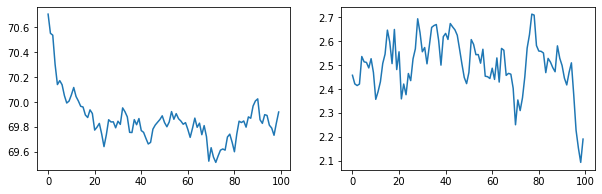

In [400]:
# traceplots of our samples to check for convergence
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
ax[0].plot(sghmc_ols_samples[:,0])
ax[1].plot(sghmc_ols_samples[:,1])
plt.show()

### Posterior Predictive Check

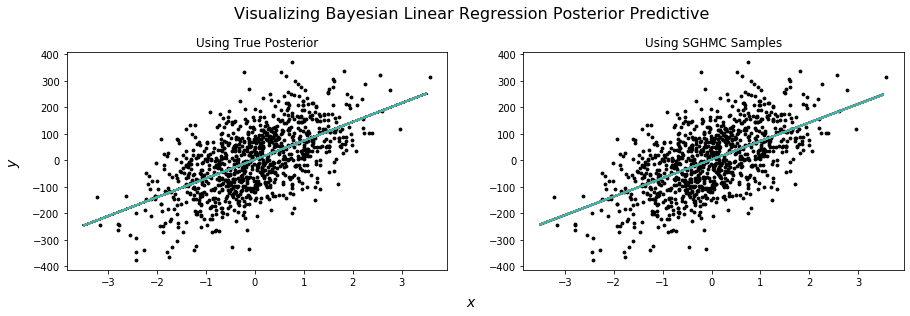

In [399]:
fig, ax = plt.subplots(1, 2, figsize = (15, 4))

ax[0].scatter(X,y, color = 'black', s = 8)
ax[1].scatter(X,y, color = 'black', s = 8)

for w in posterior_samples:
    ax[0].plot(x_range, w[0] * x_range + w[1])
    
for w in sghmc_ols_samples:
    ax[1].plot(x_range, w[0] * x_range + w[1])
    
    
ax[0].set_title("Using True Posterior")
ax[1].set_title("Using SGHMC Samples")

fig.text(0.5, 0, '$x$', ha='center', size = 14)
fig.text(0.07, 0.5, '$y$', va='center', rotation='vertical', size = 14)
fig.suptitle("Visualizing Bayesian Linear Regression Posterior Predictive", va = 'top', size = 16, y=1.04)

plt.savefig('data/posterior_predictive.png', bbox_inches="tight")
plt.show()